In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file into a DataFrame
data = pd.read_excel('INE_IPC.xlsx')



In [3]:
data.rename(columns={
    'Unnamed: 0': 'time',
    '    Índice general': 'index_general',
    '    01 Alimentos y bebidas no alcohólicas': 'food_beverages',
    '    02 Bebidas alcohólicas y tabaco': 'alc_tobacco',
    '    03 Vestido y calzado': 'clothing_footwear',
    '    04 Vivienda, agua, electricidad, gas y otros combustibles': 'housing_utilities',
    '    05 Muebles, artículos del hogar y artículos para el mantenimiento corriente del hogar': 'furniture_household',
    '    06 Sanidad': 'health',
    '    07 Transporte': 'transport',
    '    08 Comunicaciones': 'communications',
    '    09 Ocio y cultura': 'leisure_culture',
    '    10 Enseñanza': 'education',
    '    11 Restaurantes y hoteles': 'restaurants_hotels',
    '    12 Otros bienes y servicios': 'other_goods_services'
}, inplace=True)

data['time'] = pd.to_datetime(data['time'], format='%YM%m')



In [4]:
def plot_inflation(data, inflation_type):
    title = inflation_type
    plt.figure(figsize=(14, 7))

    # Line plot of inflation over time
    plt.subplot(2, 1, 1)
    plt.plot(data['time'], data[inflation_type], marker='o', color='r')
    plt.xlabel('Time')
    plt.ylabel(inflation_type.replace('_', ' ').title())
    plt.title(f'{title} Over Time')
    plt.grid(True)

    # Histogram of inflation
    plt.subplot(2, 1, 2)
    plt.hist(data[inflation_type].dropna(), bins=30, edgecolor='k', color='r')
    plt.xlabel(inflation_type.replace('_', ' ').title())
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {title}')

    plt.tight_layout()
    plt.show()

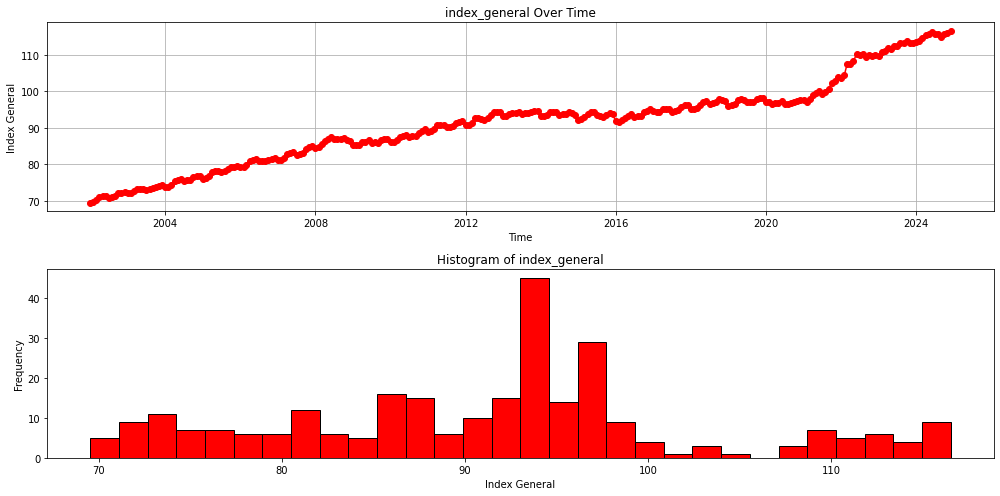

In [9]:
plot_inflation(data, 'index_general')


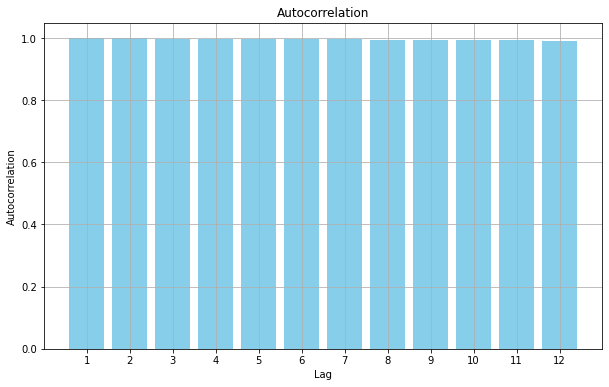

In [ ]:

def plot_autocorrelations(autocorrelations):
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, 13), autocorrelations, color='skyblue')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation')
    plt.xticks(range(1, 13))
    plt.grid(True)
    plt.show()

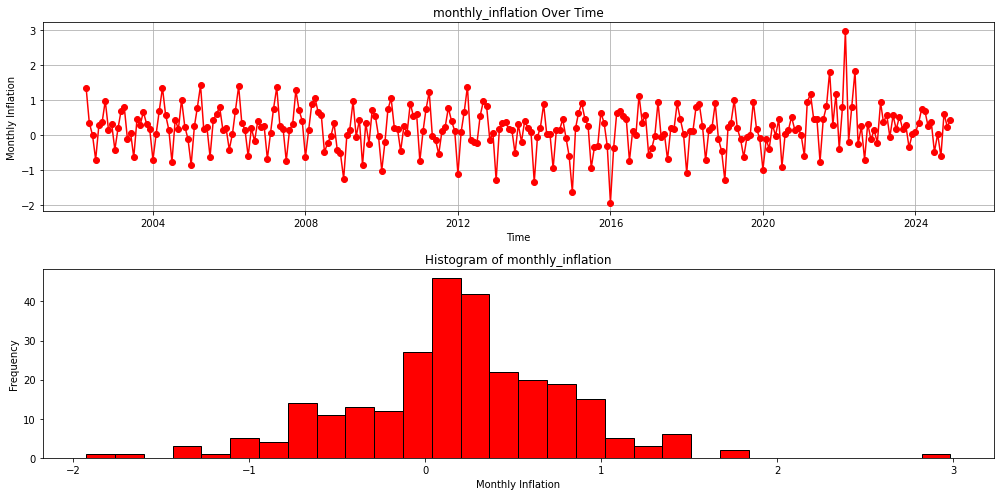

In [14]:
import numpy as np

# Calculate the monthly inflation
data['monthly_inflation'] = 100 * (np.log(data['index_general']) - np.log(data['index_general'].shift(1)))

# Drop the first row as it will have NaN value for monthly_inflation
data.dropna(subset=['monthly_inflation'], inplace=True)

plot_inflation(data, 'monthly_inflation')


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform the Dickey-Fuller test
result = adfuller(data['monthly_inflation'])

# Extract and print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])


#### WE ASSUME STATIONARITY !!!!!!!!!!!!!!!!!!!!!!!!!

ADF Statistic: -3.385427944364259
p-value: 0.011465776816000762


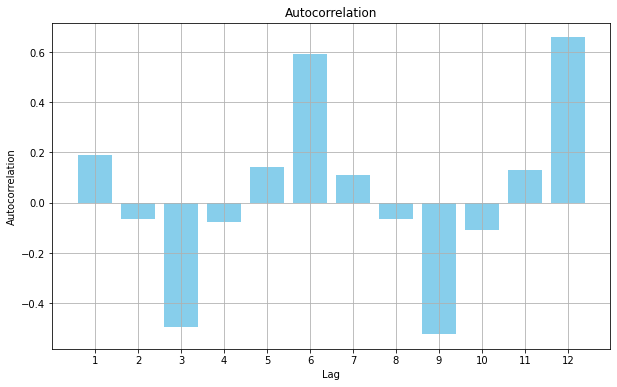

In [ ]:
autocorrelations = [data['monthly_inflation'].autocorr(lag=i) for i in range(1, 13)]
plot_autocorrelations(autocorrelations)

### OBSERVATIONS: 
# - 3rd partial correlation is 0 -> AR(2) 



## Yearly

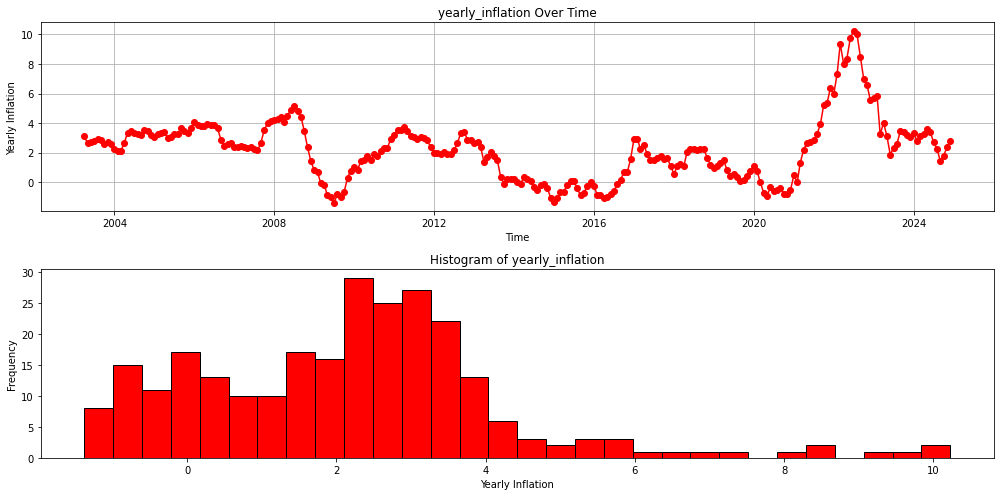

In [22]:
### Check seasonality patterns

# Calculate the monthly inflation
data['yearly_inflation'] = 100 * (np.log(data['index_general']) - np.log(data['index_general'].shift(12)))

# Drop the first row as it will have NaN value for monthly_inflation
data.dropna(subset=['yearly_inflation'], inplace=True)

plot_inflation(data, 'yearly_inflation')

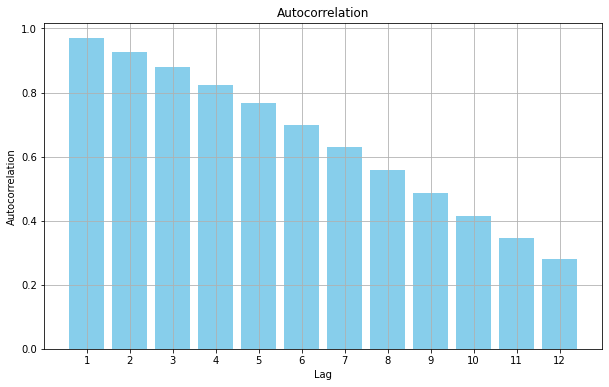

[ 1.          0.97293993 -0.26031055 -0.04672143 -0.16967087  0.00738057
 -0.24752206 -0.00204666 -0.06270531 -0.02877122 -0.02531114  0.06727605
 -0.08847374]


In [ ]:
from statsmodels.tsa.stattools import pacf

autocorrelations_yearly = [data['yearly_inflation'].autocorr(lag=i) for i in range(1, 13)]
plot_autocorrelations(autocorrelations_yearly)

partial_autocorrelations_yearly = pacf(data['yearly_inflation'], nlags=12)
print(partial_autocorrelations_yearly)

## Model: AR(1) bc 1 Partial Correlation

In [23]:
# Perform the Dickey-Fuller test
result = adfuller(data['yearly_inflation'])

# Extract and print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.8883223938491165
p-value: 0.04672289355214373


## Fit AR(1) Model

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

# Fit the AR(1) model
model = AutoReg(data['yearly_inflation'], lags=1)
model_fit = model.fit()

# Print the estimated parameters
print('Estimated parameters:', model_fit.params)

# Print the significance of the parameters
print('Significance of parameters:', model_fit.pvalues)

# Print the variance of the errors
print('Variance of the errors:', model_fit.sigma2)

# Print the Inverted AR Roots
print('Inverted AR Roots:', model_fit.roots)

### Other Program Might impose restrictions for AR Roots smaller than 1

Estimated parameters: const                  0.065262
yearly_inflation.L1    0.969548
dtype: float64
Significance of parameters: const                  0.152566
yearly_inflation.L1    0.000000
dtype: float64
Variance of the errors: 0.25800121918998625
Inverted AR Roots: [1.03140881]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


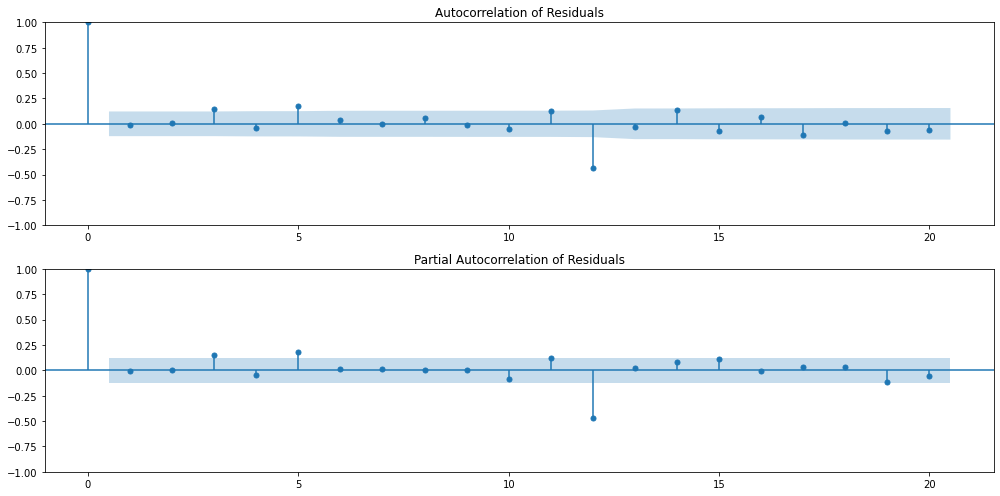

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Get the residuals from the model
residuals = model_fit.resid

# Plot the ACF and PACF of the residuals
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation of Residuals')

plt.subplot(2, 1, 2)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation of Residuals')

plt.tight_layout()
plt.show()

## Conclusion: 
# - Correlations with Past still Exists
# - We find a seasonal component at lag 12

# -> we need AR(2)

## Fit AR(2)

In [35]:
from statsmodels.tsa.ar_model import AutoReg

# Fit the AR(1) model
model = AutoReg(data['yearly_inflation'], lags=2)
model_fit_ar2 = model.fit()

# Print the estimated parameters
print('Estimated parameters:', model_fit_ar2.params)

# Print the significance of the parameters
print('Significance of parameters:', model_fit_ar2.pvalues)

# Print the variance of the errors
print('Variance of the errors:', model_fit_ar2.sigma2)

# Print the Inverted AR Roots
print('Inverted AR Roots:', model_fit_ar2.roots)

### Other Program Might impose restrictions for AR Roots smaller than 1

Estimated parameters: const                  0.082498
yearly_inflation.L1    1.204298
yearly_inflation.L2   -0.241612
dtype: float64
Significance of parameters: const                  6.371843e-02
yearly_inflation.L1    9.621425e-89
yearly_inflation.L2    6.114651e-05
dtype: float64
Variance of the errors: 0.24321591109370194
Inverted AR Roots: [1.05267669 3.93176014]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


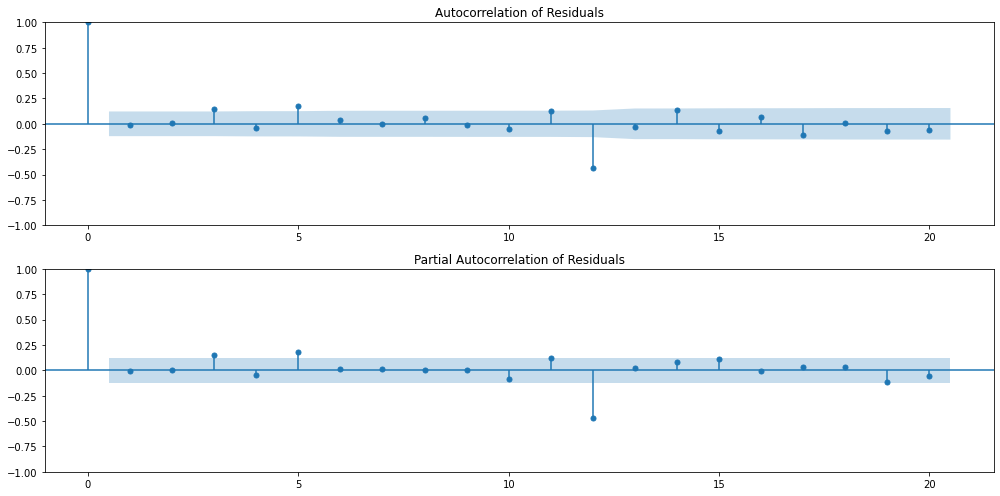

In [ ]:
# Get the residuals from the model
residuals = model_fit_ar2.resid

# Plot the ACF and PACF of the residuals
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation of Residuals')

plt.subplot(2, 1, 2)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation of Residuals')

plt.tight_layout()
plt.show()


## Oversvations
# Correlations at the beginning (should) be close to zero 
# seasonal component still exists

In [34]:
residuals

17     0.188152
18     0.070209
19     0.177642
20    -0.090330
21    -0.271031
         ...   
271   -0.320231
272   -0.660158
273    0.492971
274    0.497921
275    0.288778
Length: 259, dtype: float64

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA(2, 0, 1) model
model_arima = ARIMA(data['yearly_inflation'], order=(2, 0, 1))
model_fit_arima = model_arima.fit()

# Print the estimated parameters
print('Estimated parameters:', model_fit_arima.params)

# Print the significance of the parameters
print('Significance of parameters:', model_fit_arima.pvalues)

# Print the variance of the errors
#print('Variance of the errors:', model_fit_arima.sigma2)

# Print the Inverted AR Roots
print('Inverted AR Roots:', model_fit_arima.arroots)

# Print the Inverted MA Roots
print('Inverted MA Roots:', model_fit_arima.maroots)

# Observations
# params significant
# AR/MA Roots problematic

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Estimated parameters: const     2.247630
ar.L1     1.824439
ar.L2    -0.841346
ma.L1    -0.716141
sigma2    0.236327
dtype: float64
Significance of parameters: const      5.427559e-05
ar.L1     2.582546e-181
ar.L2      3.711845e-44
ma.L1      1.211471e-14
sigma2     1.973478e-56
dtype: float64
Inverted AR Roots: [1.08423838-0.11401281j 1.08423838+0.11401281j]
Inverted MA Roots: [1.39637291]


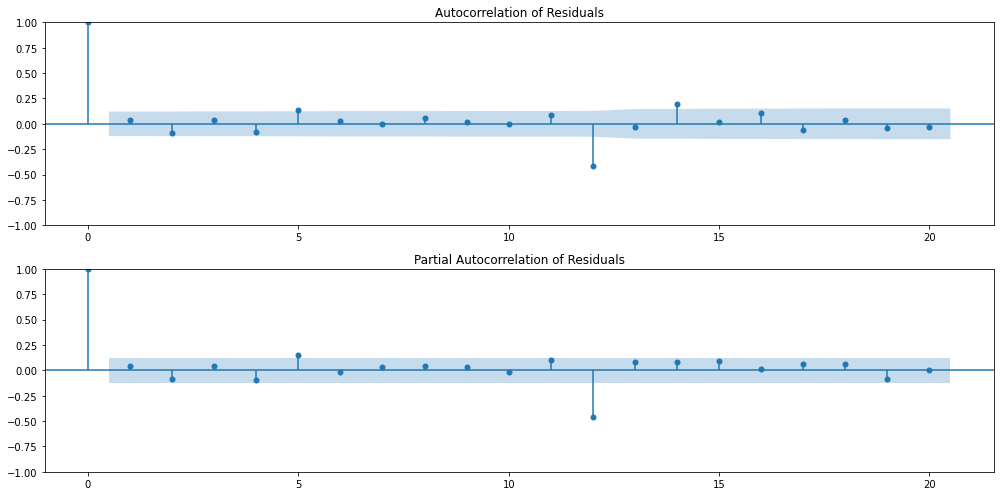

In [40]:
# Get the residuals from the model
residuals = model_fit_arima.resid

# Plot the ACF and PACF of the residuals
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation of Residuals')

plt.subplot(2, 1, 2)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation of Residuals')

plt.tight_layout()
plt.show()

## Check normality of Residuals

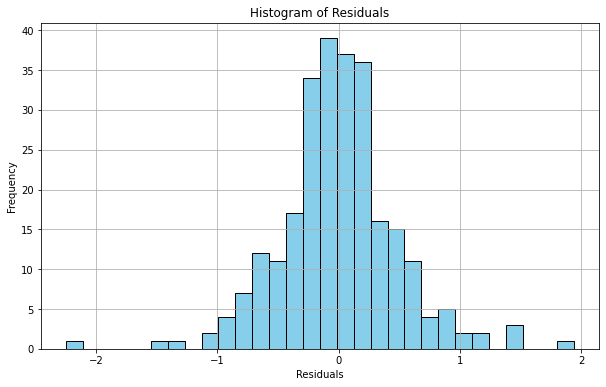

In [41]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', color='skyblue')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import jarque_bera

# Perform the Jarque-Bera test
jb_test_stat, jb_p_value = jarque_bera(residuals)

# Print the test results
print('Jarque-Bera test statistic:', jb_test_stat)
print('p-value:', jb_p_value)

### Under Normality we expect all observations [-1.2,1.2] -> We see outliers 

Jarque-Bera test statistic: 76.87431468020021
p-value: 0.0


Conclusion: 

- Consider Instastionarity -> consider one more difference
- Outliers could be result from shocks (Covid, Ukraine War)